In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import mat73
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import random
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore", message="The NumPy array is not writable")
warnings.filterwarnings("ignore", message="Mean of empty slice")

In [ ]:
# Data

class T1AugmentedDataset(Dataset):
    def __init__(self, input_data, target_data, augment=True):
        self.input_data = input_data
        self.target_data = target_data
        self.augment = augment
        
    def __len__(self):
        return len(self.input_data)
    
    def random_rotation(self, input_patch, target_patch):
        """Rotate patch by 0, 90, 180, or 270 degrees"""
        k = random.randint(0, 3)  # Number of 90-degree rotations
        return torch.rot90(input_patch, k, [1, 2]), torch.rot90(target_patch, k, [1, 2])
    
    def random_flip(self, input_patch, target_patch):
        """Randomly flip patch horizontally and/or vertically"""
        if random.random() < 0.5:
            input_patch = torch.flip(input_patch, [1])  # Flip height
            target_patch = torch.flip(target_patch, [1])
        if random.random() < 0.5:
            input_patch = torch.flip(input_patch, [2])  # Flip width
            target_patch = torch.flip(target_patch, [2])
        return input_patch, target_patch
    
    def __getitem__(self, idx):
        input_patch = self.input_data[idx]
        target_patch = self.target_data[idx]
        
        if self.augment:
            input_patch, target_patch = self.random_rotation(input_patch, target_patch)
            input_patch, target_patch = self.random_flip(input_patch, target_patch)
        
        return input_patch, target_patch

In [ ]:
# UNet Model Definition

class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels//8, kernel_size=1),
            nn.BatchNorm2d(in_channels//8),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels//8, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights
    
class ResidualDoubleConvWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(0.1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )
        self.attention = SpatialAttention(out_channels)
        self.residual = nn.Identity() if in_channels == out_channels else \
                       nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        identity = self.residual(x)
        x = self.double_conv(x)
        x = self.attention(x)
        return x + identity
    
class UNetWithAttention(nn.Module):
    def __init__(self):
        super(UNetWithAttention, self).__init__()
        
        # Encoder path
        self.conv1 = ResidualDoubleConvWithAttention(8, 64)
        self.pool1 = nn.MaxPool2d(2, padding=1)
        self.conv2 = ResidualDoubleConvWithAttention(64, 128)
        
        # Bridge
        self.bridge_conv = ResidualDoubleConvWithAttention(128, 256)
        
        # Decoder path
        self.upconv = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = ResidualDoubleConvWithAttention(192, 128)  # 192 = 128 + 64 (skip connection)
        
        # Final convolutions with attention
        self.final_conv = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            SpatialAttention(64),
            nn.Conv2d(64, 32, kernel_size=1)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoding path
        conv1 = self.conv1(x)           # [batch, 64, 9, 9]
        x = self.pool1(conv1)           # [batch, 64, 5, 5]
        conv2 = self.conv2(x)           # [batch, 128, 5, 5]
        
        # Bridge
        x = self.bridge_conv(conv2)     # [batch, 256, 5, 5]
        
        # Decoding path
        x = self.upconv(x)              # [batch, 128, 10, 10]
        x = x[:, :, :9, :9]            # [batch, 128, 9, 9]
        x = torch.cat([x, conv1], dim=1)  # [batch, 192, 9, 9]
        x = self.conv3(x)               # [batch, 128, 9, 9]
        
        # Final convolutions
        x = self.final_conv(x)          # [batch, 32, 9, 9]
        
        return x

In [4]:
# Data Loading

data = mat73.loadmat('../data/training_data_T1_3D_9x9x32x47932_noise0.05.mat')
input_noisy_np = data['input_noisy']
ref_np = data['ref']
input_noisy_np = np.nan_to_num(input_noisy_np, nan=0.0)

input_noisy_torch = np.transpose(input_noisy_np, (3, 2, 0, 1))
ref_torch = np.transpose(ref_np, (3, 2, 0, 1))

input_noisy_torch = torch.tensor(input_noisy_torch, dtype=torch.float32)
ref_torch = torch.tensor(ref_torch, dtype=torch.float32)

input_mean = input_noisy_torch.mean()
input_std = input_noisy_torch.std()
input_noisy_torch = (input_noisy_torch - input_mean) / input_std

dataset = T1AugmentedDataset(input_noisy_torch, ref_torch)

train_size = int(0.8 * len(input_noisy_torch))
val_input = input_noisy_torch[train_size:]
val_target = ref_torch[train_size:]
val_dataset = T1AugmentedDataset(val_input, val_target, augment=False)
batch_size = 64
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Load Model and Register Hooks
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetWithAttention().to(device)

checkpoint = torch.load('../models/spatial_signal_full_patch/saved_models/best_unet_model_attention_4.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

attention_weights_dict = {}

def get_attention_hook(name):
    def hook(module, input, output):
        attention_weights = output / (input[0] + 1e-8)
        attention_weights_dict[name] = attention_weights.detach().cpu().numpy()
    return hook

for name, module in model.named_modules():
    if isinstance(module, SpatialAttention):
        print(f"Registering hook for: {name}")
        module.register_forward_hook(get_attention_hook(name))

Registering hook for: conv1.attention
Registering hook for: conv2.attention
Registering hook for: bridge_conv.attention
Registering hook for: conv3.attention
Registering hook for: final_conv.3


C:\Users\trpha\AppData\Local\Temp\ipykernel_24388\786131692.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../models/spatial_signal_full_patch/

In [8]:
# Quantitative Analysis
all_attention_scores = []
all_mse_values = []
all_r2_values = []
last_attention_layer_name = None

for inputs, targets in val_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    inputs = inputs.cpu().numpy()
    targets = targets.cpu().numpy()
    outputs = outputs.cpu().numpy()

    for name, attention_weights in attention_weights_dict.items():
        last_attention_layer_name = name
    attention_weights = attention_weights_dict[last_attention_layer_name]

    for batch_idx in range(inputs.shape[0]):
        for i in range(9):
            for j in range(9):
                attention_score = attention_weights[batch_idx, :, i, j].mean()
                mse = mean_squared_error(targets[batch_idx, :, i, j], outputs[batch_idx, :, i, j])
                r2 = r2_score(targets[batch_idx, :, i, j], outputs[batch_idx, :, i, j])
                all_attention_scores.append(attention_score)
                all_mse_values.append(mse)
                all_r2_values.append(r2)

In [9]:
df = pd.DataFrame({
    'Attention': all_attention_scores,
    'MSE': all_mse_values,
    'R2': all_r2_values
})

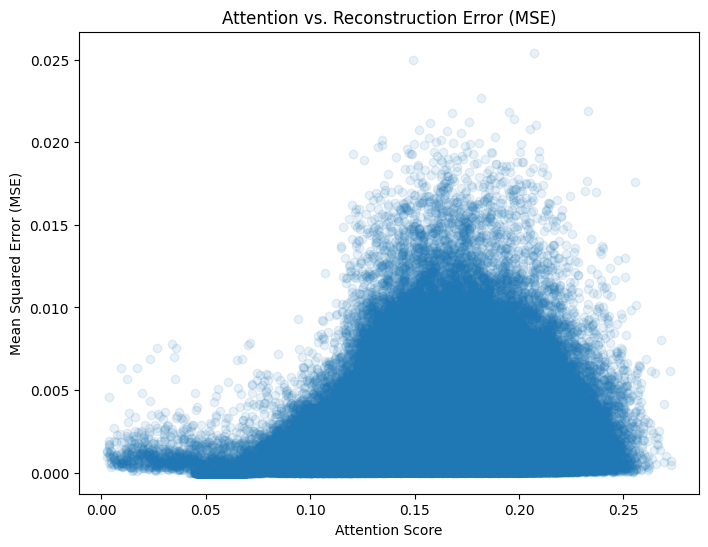

In [10]:
# Scatter Plot: Attention vs. MSE
plt.figure(figsize=(8, 6))
plt.scatter(df['Attention'], df['MSE'], alpha=0.1)
plt.xlabel('Attention Score')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Attention vs. Reconstruction Error (MSE)')
plt.show()

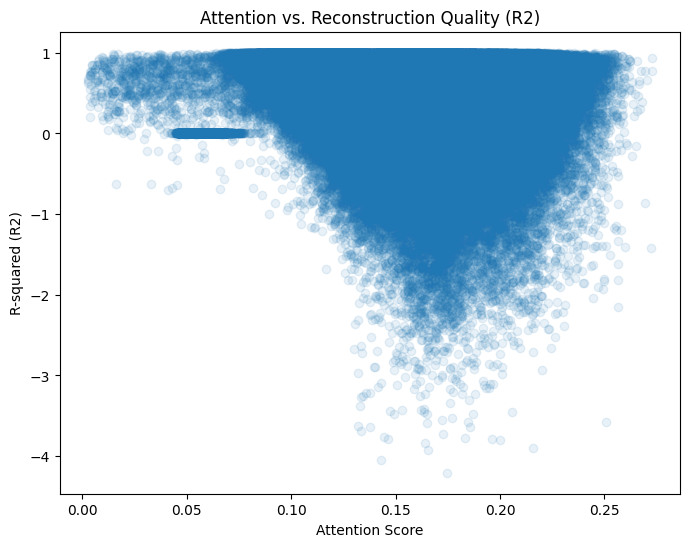

In [11]:
# Scatter Plot: Attention vs. R2
plt.figure(figsize=(8, 6))
plt.scatter(df['Attention'], df['R2'], alpha=0.1)
plt.xlabel('Attention Score')
plt.ylabel('R-squared (R2)')
plt.title('Attention vs. Reconstruction Quality (R2)')
plt.show()

In [12]:
# Correlation Coefficients
correlation = df.corr()
print("Correlation Matrix:\n", correlation)

Correlation Matrix:
            Attention       MSE        R2
Attention   1.000000  0.242040  0.128625
MSE         0.242040  1.000000 -0.488444
R2          0.128625 -0.488444  1.000000


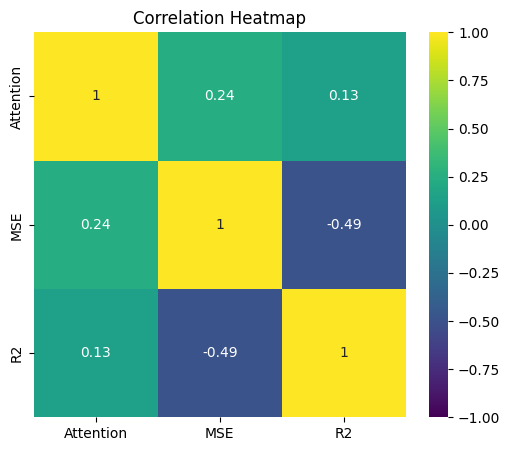

In [13]:
# Heatmap of Correlation
plt.figure(figsize=(6, 5))
sns.heatmap(correlation, annot=True, cmap='viridis', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

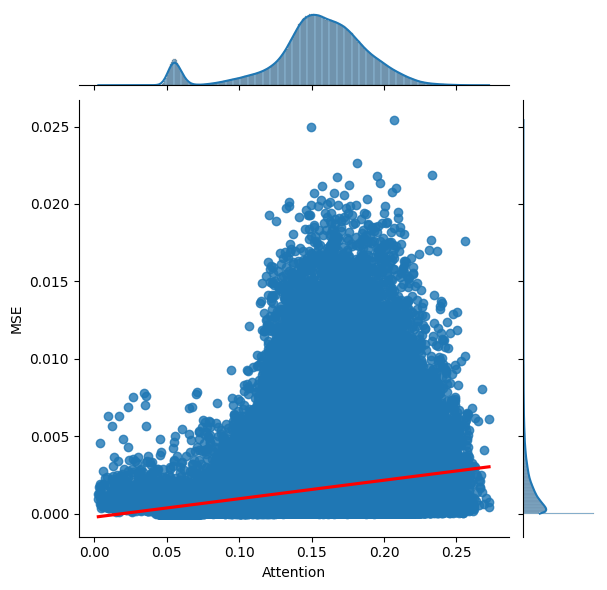

In [14]:
# Joint Plot
sns.jointplot(x='Attention', y='MSE', data=df, kind='reg', joint_kws={'line_kws':{'color':'red'}})
plt.show()

In [15]:
# Statistical Tests
corr_mse, p_value_mse = pearsonr(df['Attention'], df['MSE'])
corr_r2, p_value_r2 = pearsonr(df['Attention'], df['R2'])
print(f"Pearson Correlation (Attention, MSE): {corr_mse:.3f}, p-value: {p_value_mse:.3f}")
print(f"Pearson Correlation (Attention, R2): {corr_r2:.3f}, p-value: {p_value_r2:.3f}")

Pearson Correlation (Attention, MSE): 0.242, p-value: 0.000
Pearson Correlation (Attention, R2): 0.129, p-value: 0.000


In [16]:
# Qualitative Analysis
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)
with torch.no_grad():
    outputs = model(inputs)
inputs = inputs.cpu().numpy()
targets = targets.cpu().numpy()
outputs = outputs.cpu().numpy()
example_idx = 0

Visualizing attention weights for: conv1.attention


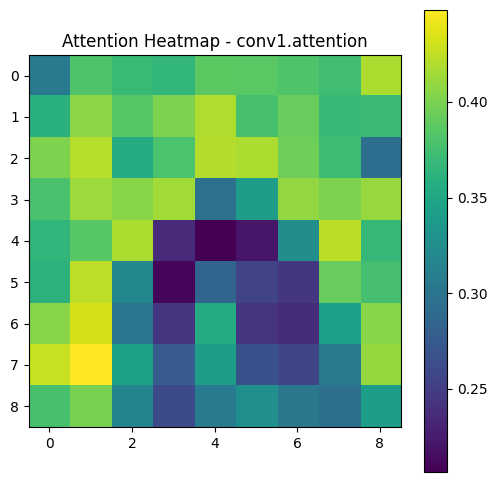

Visualizing attention weights for: conv2.attention


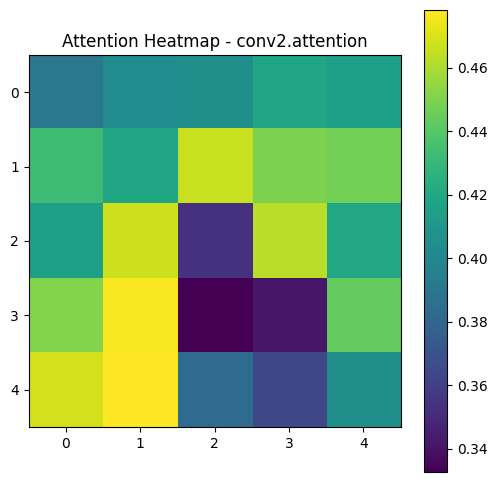

Visualizing attention weights for: bridge_conv.attention


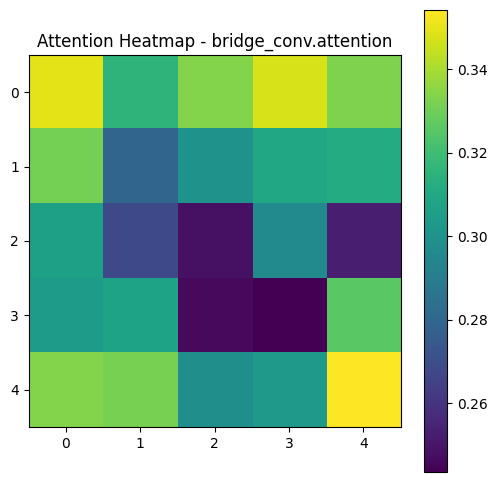

Visualizing attention weights for: conv3.attention


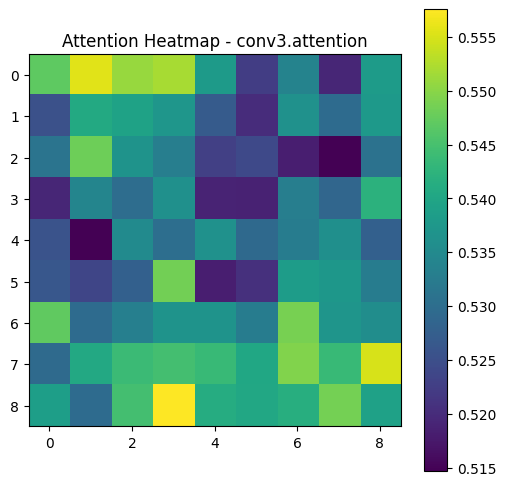

Visualizing attention weights for: final_conv.3


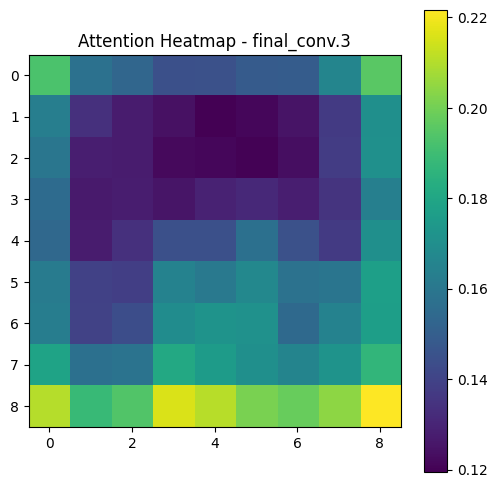

In [17]:
# Attention Heatmaps
for name, attention_weights in attention_weights_dict.items():
    print(f"Visualizing attention weights for: {name}")
    attention_map = attention_weights[example_idx].transpose(1, 2, 0)
    if attention_map.shape[2] > 1:
        attention_map = attention_map.mean(axis=2)
    plt.figure(figsize=(6, 6))
    plt.imshow(attention_map, cmap='viridis')
    plt.title(f'Attention Heatmap - {name}')
    plt.colorbar()
    plt.show()
    last_attention_layer_name = name

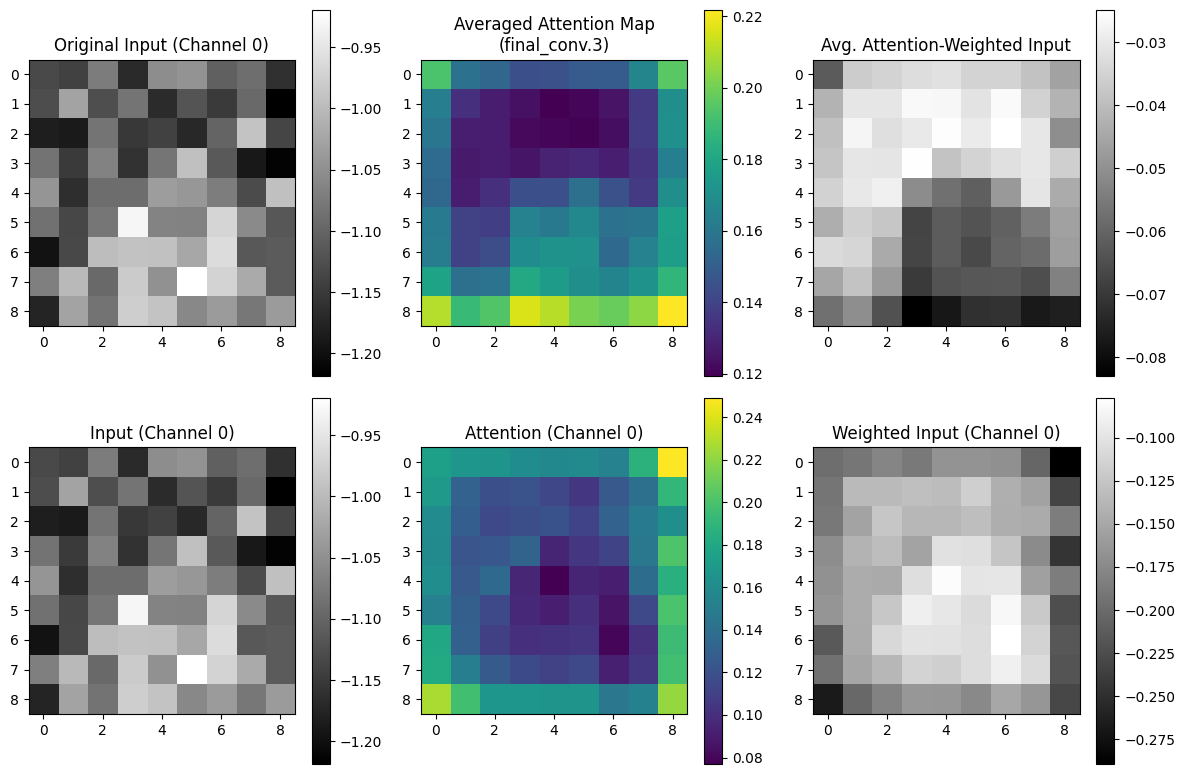

In [18]:
# Attention-Weighted Input
if last_attention_layer_name is not None:
    attention_weights = attention_weights_dict[last_attention_layer_name][example_idx]
    averaged_attention = attention_weights.mean(axis=0)
    weighted_input_avg = inputs[example_idx] * averaged_attention[None, :, :]

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(inputs[example_idx, 0, :, :], cmap='gray')
    plt.title('Original Input (Channel 0)')
    plt.colorbar()

    plt.subplot(2, 3, 2)
    plt.imshow(averaged_attention, cmap='viridis')
    plt.title(f'Averaged Attention Map\n({last_attention_layer_name})')
    plt.colorbar()

    plt.subplot(2, 3, 3)
    plt.imshow(weighted_input_avg.mean(axis=0), cmap='gray')
    plt.title('Avg. Attention-Weighted Input')
    plt.colorbar()

    if last_attention_layer_name == 'final_conv.3':
        selected_channel = 0
        weighted_input_selected = inputs[example_idx, selected_channel, :, :] * attention_weights[selected_channel, :, :]
        plt.subplot(2, 3, 4)
        plt.imshow(inputs[example_idx, selected_channel, :, :], cmap='gray')
        plt.title(f'Input (Channel {selected_channel})')
        plt.colorbar()
        plt.subplot(2, 3, 5)
        plt.imshow(attention_weights[selected_channel, :, :], cmap='viridis')
        plt.title(f'Attention (Channel {selected_channel})')
        plt.colorbar()
        plt.subplot(2, 3, 6)
        plt.imshow(weighted_input_selected, cmap='gray')
        plt.title(f'Weighted Input (Channel {selected_channel})')
        plt.colorbar()
    else:
        print("Skipping channel-specific visualization")
    plt.tight_layout()
    plt.show()
else:
    print("No attention weights found.")

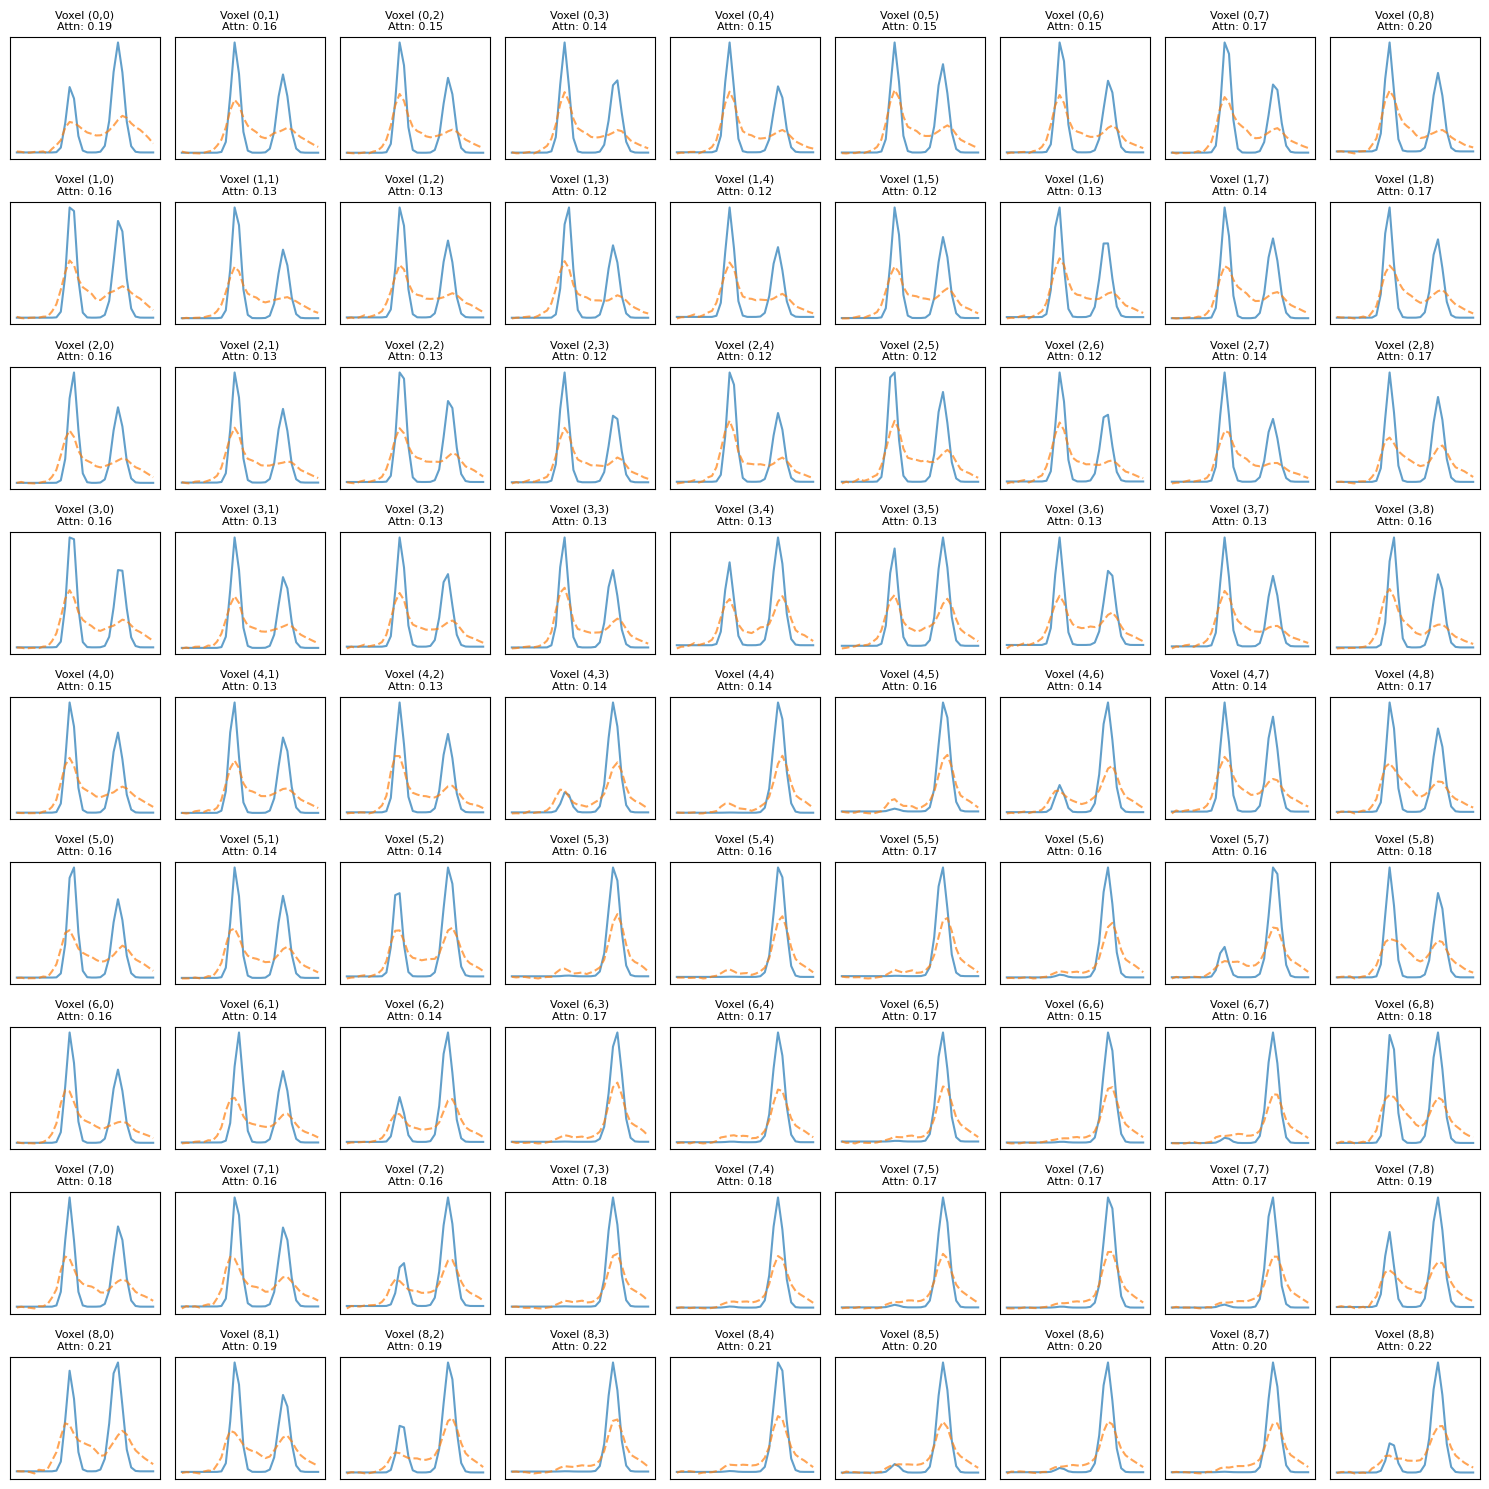

In [19]:
# Spectrum Plots
if last_attention_layer_name is not None:
    attention_weights = attention_weights_dict[last_attention_layer_name][example_idx]
    averaged_attention = attention_weights.mean(axis=0)
    plt.figure(figsize=(15, 15))
    colors = sns.color_palette()
    for i in range(9):
        for j in range(9):
            plt.subplot(9, 9, i * 9 + j + 1)
            attention_score = averaged_attention[i, j]
            plt.plot(targets[example_idx, :, i, j], color=colors[0], alpha=0.7, label='Target')
            plt.plot(outputs[example_idx, :, i, j], color=colors[1], linestyle='--', alpha=0.7, label='Prediction')
            plt.title(f'Voxel ({i},{j})\nAttn: {attention_score:.2f}', fontsize=8)
            plt.xticks([])
            plt.yticks([])
    plt.tight_layout()
    plt.show()
else:
    print("No attention weights found.")